In [2]:
import pydub
import pandas as pd
import librosa as lb
import numpy as np
import os
import random
from linetimer import CodeTimer

C:\Users\Risto\Anaconda3\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [3]:
def osPath(path):
    return os.path.abspath(path)

In [4]:
pathname = "data/data files/validated.tsv"
output_pathname = "Datasets/Dataset_ENG.tsv"
os.environ["PATH"] += os.pathsep + 'FFMPEG/bin'
mp3_folder = "data/clips"
wav_folder = "data/wav_clips"

# Feature Extraction

In [4]:
df = pd.read_csv(pathname, sep="\t")
df

FileNotFoundError: [Errno 2] File b'data/data files/validated.tsv' does not exist: b'data/data files/validated.tsv'

In [5]:
df = df.dropna(subset=["age","gender","accent"]) # This will DEFINITELY lead to a smaller sample size and less reliable results, but for simplicity's and comparison's sake, let's only go with the data that also includes accents and ages.

# df = df[df.gender != "other"] # Let's not remove these right away. We can run an experiment on whether models are affected by this or not.

df = df[["up_votes","down_votes","path", "age", "gender","accent"]] # Might be a good idea to keep up_votes nad down_votes as well, so I added these.

df

,up_votes,down_votes,path,age,gender,accent
8,2,0,common_voice_en_18489793.mp3,thirties,male,us
11,2,0,common_voice_en_17779714.mp3,thirties,male,canada
40,2,1,common_voice_en_125399.mp3,seventies,female,england
44,2,1,common_voice_en_18274221.mp3,twenties,male,us
54,2,0,common_voice_en_17147389.mp3,twenties,male,us
...,...,...,...,...,...,...
638031,2,0,common_voice_en_18829416.mp3,sixties,male,us
638032,2,0,common_voice_en_18829417.mp3,sixties,male,us
638033,2,0,common_voice_en_18829418.mp3,sixties,male,us
638034,2,0,common_voice_en_18829419.mp3,sixties,male,us


In [6]:
# New Columns
column_chroma_stft = [] #chromagram https://en.wikipedia.org/wiki/Chroma_feature
column_rms = [] #root mean square https://en.wikipedia.org/wiki/Root_mean_square#In_common_waveforms
column_spec_cent = [] #spectral centroid https://en.wikipedia.org/wiki/Spectral_centroid
column_spec_bw = [] #spectral bandwidth https://en.wikipedia.org/wiki/Bandwidth_(signal_processing)#x_dB_bandwidth
column_rolloff = [] #spectral roll-off https://en.wikipedia.org/wiki/Roll-off
column_zcr = [] #zero-crossing rate https://en.wikipedia.org/wiki/Zero-crossing_rate
column_mfcc1 = [] #Mel-frequency cepstrum coefficients https://en.wikipedia.org/wiki/Mel-frequency_cepstrum
column_mfcc2 = []
column_mfcc3 = []
column_mfcc4 = []
column_mfcc5 = []
column_mfcc6 = []
column_mfcc7 = []
column_mfcc8 = []
column_mfcc9 = []
column_mfcc10 = []
column_mfcc11 = []
column_mfcc12 = []
column_mfcc13 = []
column_mfcc14 = []
column_mfcc15 = []
column_mfcc16 = []
column_mfcc17 = []
column_mfcc18 = []
column_mfcc19 = []
column_mfcc20 = []

In [7]:
# Get all audio file paths and names
wav_FilePaths = []
mp3_FileNames = []
dir = os.fsdecode(wav_folder)
for path in os.listdir(dir):
    src = os.path.join(dir, path)
    name = path[:-3] + str("mp3")
    wav_FilePaths.append(src)
    mp3_FileNames.append(name)

In [8]:
# Remove all entries from dataframe where we don't have the given audio file
df = df[df["path"].isin(mp3_FileNames)]
dictionary = dict(zip(mp3_FileNames, wav_FilePaths))
df["path"] = df["path"].map(dictionary)

C:\Users\Frederik\Anaconda3\envs\Py3_IDS\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [9]:
df

,up_votes,down_votes,path,age,gender,accent
40,2,1,data/wav_clips\common_voice_en_125399.wav,seventies,female,england
199,2,0,data/wav_clips\common_voice_en_1100186.wav,sixties,male,african
219,2,0,data/wav_clips\common_voice_en_1272597.wav,twenties,male,indian
396,2,0,data/wav_clips\common_voice_en_18354220.wav,twenties,female,england
611,2,0,data/wav_clips\common_voice_en_15734801.wav,fourties,male,scotland
...,...,...,...,...,...,...
637541,2,0,data/wav_clips\common_voice_en_18819172.wav,sixties,male,us
637545,2,0,data/wav_clips\common_voice_en_18819186.wav,sixties,male,us
637627,2,0,data/wav_clips\common_voice_en_18819325.wav,sixties,male,us
637745,2,0,data/wav_clips\common_voice_en_18822358.wav,sixties,male,us


In [10]:
# Get speech features, add them to the dataframe and export to csv file
for index, row in df.iterrows():
    y, sr = lb.load(osPath(row.path))

    chroma_stft = np.mean(lb.feature.chroma_stft(y=y, sr=sr))
    #https://librosa.github.io/librosa/generated/librosa.feature.chroma_stft.html
    rms = np.mean(lb.feature.rms(y=y))
    #https://librosa.github.io/librosa/generated/librosa.feature.rms.html
    spec_cent = np.mean(lb.feature.spectral_centroid(y=y, sr=sr))
    #https://librosa.github.io/librosa/generated/librosa.feature.spectral_centroid.html
    spec_bw = np.mean(lb.feature.spectral_bandwidth(y=y, sr=sr))
    #https://librosa.github.io/librosa/generated/librosa.feature.spectral_bandwidth.html
    rolloff = np.mean(lb.feature.spectral_rolloff(y=y, sr=sr))
    #https://librosa.github.io/librosa/generated/librosa.feature.spectral_rolloff.html
    zcr = np.mean(lb.feature.zero_crossing_rate(y))
    #https://librosa.github.io/librosa/generated/librosa.feature.zero_crossing_rate.html
    mfcc = lb.feature.mfcc(y=y, sr=sr)
    #https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html

    column_chroma_stft.append(chroma_stft)
    column_rms.append(rms)
    column_spec_cent.append(spec_cent)
    column_spec_bw.append(spec_bw)
    column_rolloff.append(rolloff)
    column_zcr.append(zcr)

    column_mfcc1.append(np.mean(mfcc[0]))
    column_mfcc2.append(np.mean(mfcc[1]))
    column_mfcc3.append(np.mean(mfcc[2]))
    column_mfcc4.append(np.mean(mfcc[3]))
    column_mfcc5.append(np.mean(mfcc[4]))
    column_mfcc6.append(np.mean(mfcc[5]))
    column_mfcc7.append(np.mean(mfcc[6]))
    column_mfcc8.append(np.mean(mfcc[7]))
    column_mfcc9.append(np.mean(mfcc[8]))
    column_mfcc10.append(np.mean(mfcc[9]))
    column_mfcc11.append(np.mean(mfcc[10]))
    column_mfcc12.append(np.mean(mfcc[11]))
    column_mfcc13.append(np.mean(mfcc[12]))
    column_mfcc14.append(np.mean(mfcc[13]))
    column_mfcc15.append(np.mean(mfcc[14]))
    column_mfcc16.append(np.mean(mfcc[15]))
    column_mfcc17.append(np.mean(mfcc[16]))
    column_mfcc18.append(np.mean(mfcc[17]))
    column_mfcc19.append(np.mean(mfcc[18]))
    column_mfcc20.append(np.mean(mfcc[19]))

In [11]:
# Add columns to dataframe
df = df.assign(chroma_stft=column_chroma_stft)
df = df.assign(rms=column_rms)
df = df.assign(spec_cent=column_spec_cent)
df = df.assign(spec_bw=column_spec_bw)
df = df.assign(rolloff=column_rolloff)
df = df.assign(zcr=column_zcr)

df = df.assign(mfcc1=column_mfcc1)
df = df.assign(mfcc2=column_mfcc2)
df = df.assign(mfcc3=column_mfcc3)
df = df.assign(mfcc4=column_mfcc4)
df = df.assign(mfcc5=column_mfcc5)
df = df.assign(mfcc6=column_mfcc6)
df = df.assign(mfcc7=column_mfcc7)
df = df.assign(mfcc8=column_mfcc8)
df = df.assign(mfcc9=column_mfcc9)
df = df.assign(mfcc10=column_mfcc10)
df = df.assign(mfcc11=column_mfcc11)
df = df.assign(mfcc12=column_mfcc12)
df = df.assign(mfcc13=column_mfcc13)
df = df.assign(mfcc14=column_mfcc14)
df = df.assign(mfcc15=column_mfcc15)
df = df.assign(mfcc16=column_mfcc16)
df = df.assign(mfcc17=column_mfcc17)
df = df.assign(mfcc18=column_mfcc18)
df = df.assign(mfcc19=column_mfcc19)
df = df.assign(mfcc20=column_mfcc20)

In [12]:
df.to_csv(output_pathname, encoding="utf-8", sep="\t", index=False)

In [13]:
df

,up_votes,down_votes,path,age,gender,accent,chroma_stft,rms,spec_cent,spec_bw,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
40,2,1,data/wav_clips\common_voice_en_125399.wav,seventies,female,england,0.365858,0.115715,749.461161,1098.897685,...,-2.856971,-3.027623,-4.218188,-3.524858,-2.171703,-3.582045,-6.109649,-4.734843,-3.389881,-3.896086
199,2,0,data/wav_clips\common_voice_en_1100186.wav,sixties,male,african,0.410334,0.040648,2267.620595,2404.396326,...,-10.669424,-1.874942,-4.879779,-1.593734,-4.482958,-0.079174,-7.289438,0.110350,-5.070335,-0.253545
219,2,0,data/wav_clips\common_voice_en_1272597.wav,twenties,male,indian,0.345455,0.031659,1612.923649,1703.784527,...,-11.175241,12.403630,-0.707115,-10.989146,5.282956,-4.065197,-13.469048,-0.858188,-6.580098,-0.527497
396,2,0,data/wav_clips\common_voice_en_18354220.wav,twenties,female,england,0.321885,0.049650,2182.273597,1690.673251,...,-8.489103,-15.566792,-8.552410,-6.938752,-7.111887,-12.982553,-5.543273,-2.269802,-9.797567,-0.697005
611,2,0,data/wav_clips\common_voice_en_15734801.wav,fourties,male,scotland,0.432749,0.019544,2456.893685,2577.651628,...,-6.922030,4.514844,-8.474165,3.093559,-5.899485,3.682870,-0.608785,-0.272467,-4.542766,2.137483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637541,2,0,data/wav_clips\common_voice_en_18819172.wav,sixties,male,us,0.452195,0.068775,2612.592851,1936.058494,...,-7.232781,-4.111032,-6.217436,-1.402802,2.498643,-2.035199,-1.859134,-0.168663,-3.004894,3.106332
637545,2,0,data/wav_clips\common_voice_en_18819186.wav,sixties,male,us,0.465885,0.072035,2433.986338,1880.403386,...,-10.912062,-7.812710,-4.335599,-3.157963,1.017951,-3.971588,-2.111831,0.590116,-2.986250,5.327380
637627,2,0,data/wav_clips\common_voice_en_18819325.wav,sixties,male,us,0.496139,0.059773,2899.861998,2069.013057,...,-4.796014,-2.736257,-6.262944,-1.107921,2.475584,-0.847767,-0.785974,0.889395,-2.978726,2.341992
637745,2,0,data/wav_clips\common_voice_en_18822358.wav,sixties,male,us,0.490005,0.055018,2259.298682,1915.028359,...,-16.130146,1.807398,-6.351277,-4.038036,6.428793,-10.838871,1.197704,1.194029,-5.797193,6.492839


# Unsure we're handling some features correctly
## Or what does it mean to take means

In [5]:
from matplotlib import pyplot as plt
import pydub
from pydub import AudioSegment
from pydub.playback import play
import pandas as pd
import librosa as lb
import librosa.display
import numpy as np
import os

C:\Users\Risto\Anaconda3\lib\site-packages\pydub\utils.py:179: RuntimeWarning: Couldn't find ffplay or avplay - defaulting to ffplay, but may not work
  warn("Couldn't find ffplay or avplay - defaulting to ffplay, but may not work", RuntimeWarning)


In [6]:
def librosaFeatureDisplay(feature,title):
    lb.display.specshow(feature)
    plt.title(title)
    plt.show()
    print("mean",np.mean(feature))
    print("standard deviation",np.std(feature))

In [7]:
df = pd.read_csv(output_pathname, encoding="utf-8", sep="\t")
df

,up_votes,down_votes,path,age,gender,accent,chroma_stft,rms,spec_cent,spec_bw,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,2,1,data/wav_clips\common_voice_en_125399.wav,seventies,female,england,0.365858,0.115715,749.461161,1098.897685,...,-2.856971,-3.027623,-4.218188,-3.524858,-2.171703,-3.582045,-6.109649,-4.734843,-3.389881,-3.896086
1,2,0,data/wav_clips\common_voice_en_1100186.wav,sixties,male,african,0.410334,0.040648,2267.620595,2404.396326,...,-10.669424,-1.874942,-4.879779,-1.593734,-4.482958,-0.079174,-7.289438,0.110350,-5.070335,-0.253545
2,2,0,data/wav_clips\common_voice_en_1272597.wav,twenties,male,indian,0.345455,0.031659,1612.923649,1703.784527,...,-11.175241,12.403630,-0.707115,-10.989146,5.282956,-4.065197,-13.469048,-0.858188,-6.580098,-0.527497
3,2,0,data/wav_clips\common_voice_en_18354220.wav,twenties,female,england,0.321885,0.049650,2182.273597,1690.673251,...,-8.489103,-15.566792,-8.552410,-6.938752,-7.111887,-12.982553,-5.543273,-2.269802,-9.797567,-0.697005
4,2,0,data/wav_clips\common_voice_en_15734801.wav,fourties,male,scotland,0.432749,0.019544,2456.893685,2577.651628,...,-6.922030,4.514844,-8.474165,3.093559,-5.899485,3.682870,-0.608785,-0.272467,-4.542766,2.137483
5,2,1,data/wav_clips\common_voice_en_13643569.wav,seventies,male,us,0.556968,0.047199,3003.980082,2845.405275,...,6.298511,-1.545525,1.914656,4.260598,1.209512,6.071092,-4.060466,3.243502,-0.701524,5.362822
6,2,1,data/wav_clips\common_voice_en_15757435.wav,twenties,male,england,0.344096,0.023608,1690.789408,1547.303004,...,-3.292651,-15.204454,-0.000798,-4.348715,-1.191053,1.527506,-9.502416,-4.400562,-9.168544,-12.023730
7,4,1,data/wav_clips\common_voice_en_106966.wav,seventies,female,us,0.531139,0.002191,2198.639010,2559.337267,...,-2.912038,-0.302183,0.375967,-2.462975,-6.718711,-1.659369,-6.059867,-4.248517,-3.012985,-3.323292
8,2,0,data/wav_clips\common_voice_en_17507716.wav,teens,female,other,0.269595,0.114961,1785.720819,1554.137874,...,-12.025450,-6.061091,-5.963960,-0.858532,-12.246932,-4.106375,-6.313654,-9.611370,-1.317794,-9.443284
9,2,1,data/wav_clips\common_voice_en_159722.wav,fourties,female,us,0.414330,0.038784,2087.945091,2466.205076,...,-1.990287,-4.571713,-4.240748,1.494991,-3.444269,-2.720220,-1.060798,-0.386221,-4.826453,-1.842327


In [8]:
def present_values(row):
    y, sr = lb.load(osPath(row.path))
    lb.display.waveplot(y=y, sr=sr)
    plt.title(row.path)
    plt.show()
    print(row.path)
    librosaFeatureDisplay(lb.feature.chroma_stft(y=y, sr=sr),"Chromagram")
    librosaFeatureDisplay(lb.feature.rms(y=y),"Root Mean Square")
    librosaFeatureDisplay(lb.feature.spectral_centroid(y=y, sr=sr),"Spectral Centroid")
    librosaFeatureDisplay(lb.feature.spectral_bandwidth(y=y, sr=sr),"Spectral Bandwidth")
    librosaFeatureDisplay(lb.feature.spectral_rolloff(y=y, sr=sr),"Spectral Rolloff")
    librosaFeatureDisplay(lb.feature.zero_crossing_rate(y),"Zero-Crossing Rate")
    librosaFeatureDisplay(lb.feature.mfcc(y=y, sr=sr),"Mel-Frequency Ceptral Coefficient")

In [9]:
def play_sound(row):
    print("DOESN'T WORK")
    play(AudioSegment.from_wav(osPath(row.path)))

In [20]:
present_values(df.iloc[0,:])

AttributeError: 'Series' object has no attribute 'path'

In [21]:
play_sound(df.iloc[1,:])

DOESN'T WORK


AttributeError: 'Series' object has no attribute 'path'

# Modelling

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
plt.style.use('ggplot')

In [11]:
df = pd.read_csv(output_pathname, encoding="utf-8", sep="\t")
df

,up_votes,down_votes,path,age,gender,accent,chroma_stft,rms,spec_cent,spec_bw,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,2,1,data/wav_clips\common_voice_en_125399.wav,seventies,female,england,0.365858,0.115715,749.461161,1098.897685,...,-2.856971,-3.027623,-4.218188,-3.524858,-2.171703,-3.582045,-6.109649,-4.734843,-3.389881,-3.896086
1,2,0,data/wav_clips\common_voice_en_1100186.wav,sixties,male,african,0.410334,0.040648,2267.620595,2404.396326,...,-10.669424,-1.874942,-4.879779,-1.593734,-4.482958,-0.079174,-7.289438,0.110350,-5.070335,-0.253545
2,2,0,data/wav_clips\common_voice_en_1272597.wav,twenties,male,indian,0.345455,0.031659,1612.923649,1703.784527,...,-11.175241,12.403630,-0.707115,-10.989146,5.282956,-4.065197,-13.469048,-0.858188,-6.580098,-0.527497
3,2,0,data/wav_clips\common_voice_en_18354220.wav,twenties,female,england,0.321885,0.049650,2182.273597,1690.673251,...,-8.489103,-15.566792,-8.552410,-6.938752,-7.111887,-12.982553,-5.543273,-2.269802,-9.797567,-0.697005
4,2,0,data/wav_clips\common_voice_en_15734801.wav,fourties,male,scotland,0.432749,0.019544,2456.893685,2577.651628,...,-6.922030,4.514844,-8.474165,3.093559,-5.899485,3.682870,-0.608785,-0.272467,-4.542766,2.137483
5,2,1,data/wav_clips\common_voice_en_13643569.wav,seventies,male,us,0.556968,0.047199,3003.980082,2845.405275,...,6.298511,-1.545525,1.914656,4.260598,1.209512,6.071092,-4.060466,3.243502,-0.701524,5.362822
6,2,1,data/wav_clips\common_voice_en_15757435.wav,twenties,male,england,0.344096,0.023608,1690.789408,1547.303004,...,-3.292651,-15.204454,-0.000798,-4.348715,-1.191053,1.527506,-9.502416,-4.400562,-9.168544,-12.023730
7,4,1,data/wav_clips\common_voice_en_106966.wav,seventies,female,us,0.531139,0.002191,2198.639010,2559.337267,...,-2.912038,-0.302183,0.375967,-2.462975,-6.718711,-1.659369,-6.059867,-4.248517,-3.012985,-3.323292
8,2,0,data/wav_clips\common_voice_en_17507716.wav,teens,female,other,0.269595,0.114961,1785.720819,1554.137874,...,-12.025450,-6.061091,-5.963960,-0.858532,-12.246932,-4.106375,-6.313654,-9.611370,-1.317794,-9.443284
9,2,1,data/wav_clips\common_voice_en_159722.wav,fourties,female,us,0.414330,0.038784,2087.945091,2466.205076,...,-1.990287,-4.571713,-4.240748,1.494991,-3.444269,-2.720220,-1.060798,-0.386221,-4.826453,-1.842327


# Normalized standard deviation

In [30]:
df.mean()/df.std() #Standard deviation compared to mean

up_votes       0.788525
down_votes     0.215284
chroma_stft    7.014171
rms            1.315038
spec_cent      3.901996
spec_bw        5.337744
rolloff        4.022981
zcr            2.369316
mfcc1         -4.486102
mfcc2          3.406756
mfcc3          0.078225
mfcc4          1.613409
mfcc5          0.203886
mfcc6          0.103276
mfcc7         -0.689030
mfcc8         -0.714478
mfcc9         -1.111779
mfcc10        -0.472391
mfcc11        -1.023371
mfcc12        -0.669068
mfcc13        -0.953135
mfcc14        -0.632351
mfcc15        -0.562931
mfcc16        -0.531897
mfcc17        -1.458798
mfcc18        -0.512257
mfcc19        -1.298967
mfcc20        -0.652222
dtype: float64

# Data Balance

In [12]:
def distribution_plotter(plot_data,feature):
    counts = plot_data[feature].value_counts()
    counts = counts/sum(counts)
    counts.plot(kind="bar")
    plt.title(feature + " distribution")
    plt.show()
    

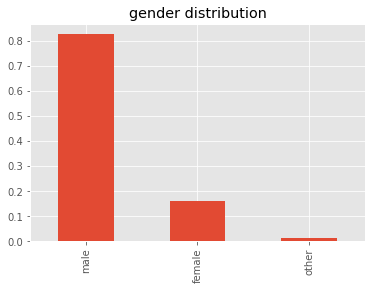

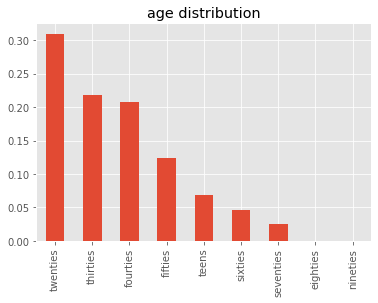

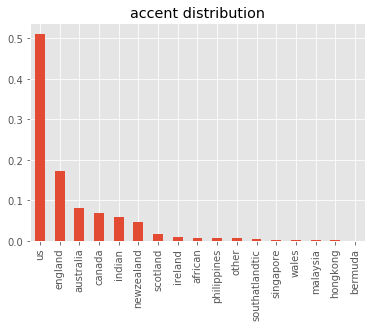

In [13]:
distribution_plotter(df,"gender")
distribution_plotter(df,"age")
distribution_plotter(df,"accent")

### Balancing the Data

In [14]:
minimum_count = 100
data_gender = df.copy()
data_age = df.copy()
data_accent = df.copy()

In [15]:
def dataBalancer(unbalanced_data,feature,floor):
    
    # Removing feature categories that are too small to predict
    counts = unbalanced_data[feature].value_counts()
    for index, value in counts.iteritems():
        if (value < floor):
            unbalanced_data = unbalanced_data[unbalanced_data[feature] != index]
    
    # Taking the largest possible sample of each feature category so that they would be balanced
    counts = unbalanced_data[feature].value_counts()
    lowest_count = min(counts)
    balanced_data = unbalanced_data.copy().head(0)
    for index, value in counts.iteritems():
        index_sample = unbalanced_data[unbalanced_data[feature] == index].sample(lowest_count)
        balanced_data = balanced_data.append(index_sample,ignore_index=True,sort=False)
    
    return balanced_data
    

In [16]:
data_gender = dataBalancer(data_gender,"gender",minimum_count)
data_age = dataBalancer(data_age,"age",minimum_count)
data_accent = dataBalancer(data_accent,"accent",minimum_count)

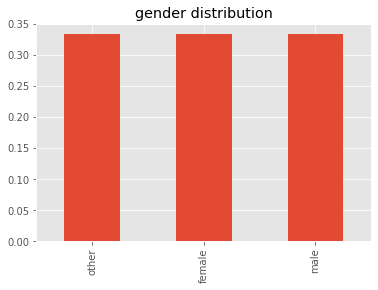

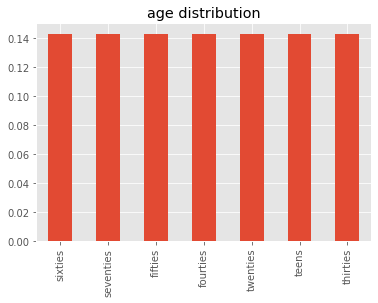

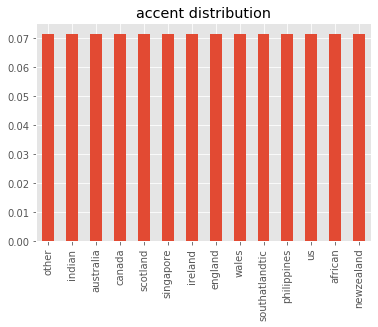

In [14]:
distribution_plotter(data_gender,"gender")
distribution_plotter(data_age,"age")
distribution_plotter(data_accent,"accent")

# Visualization

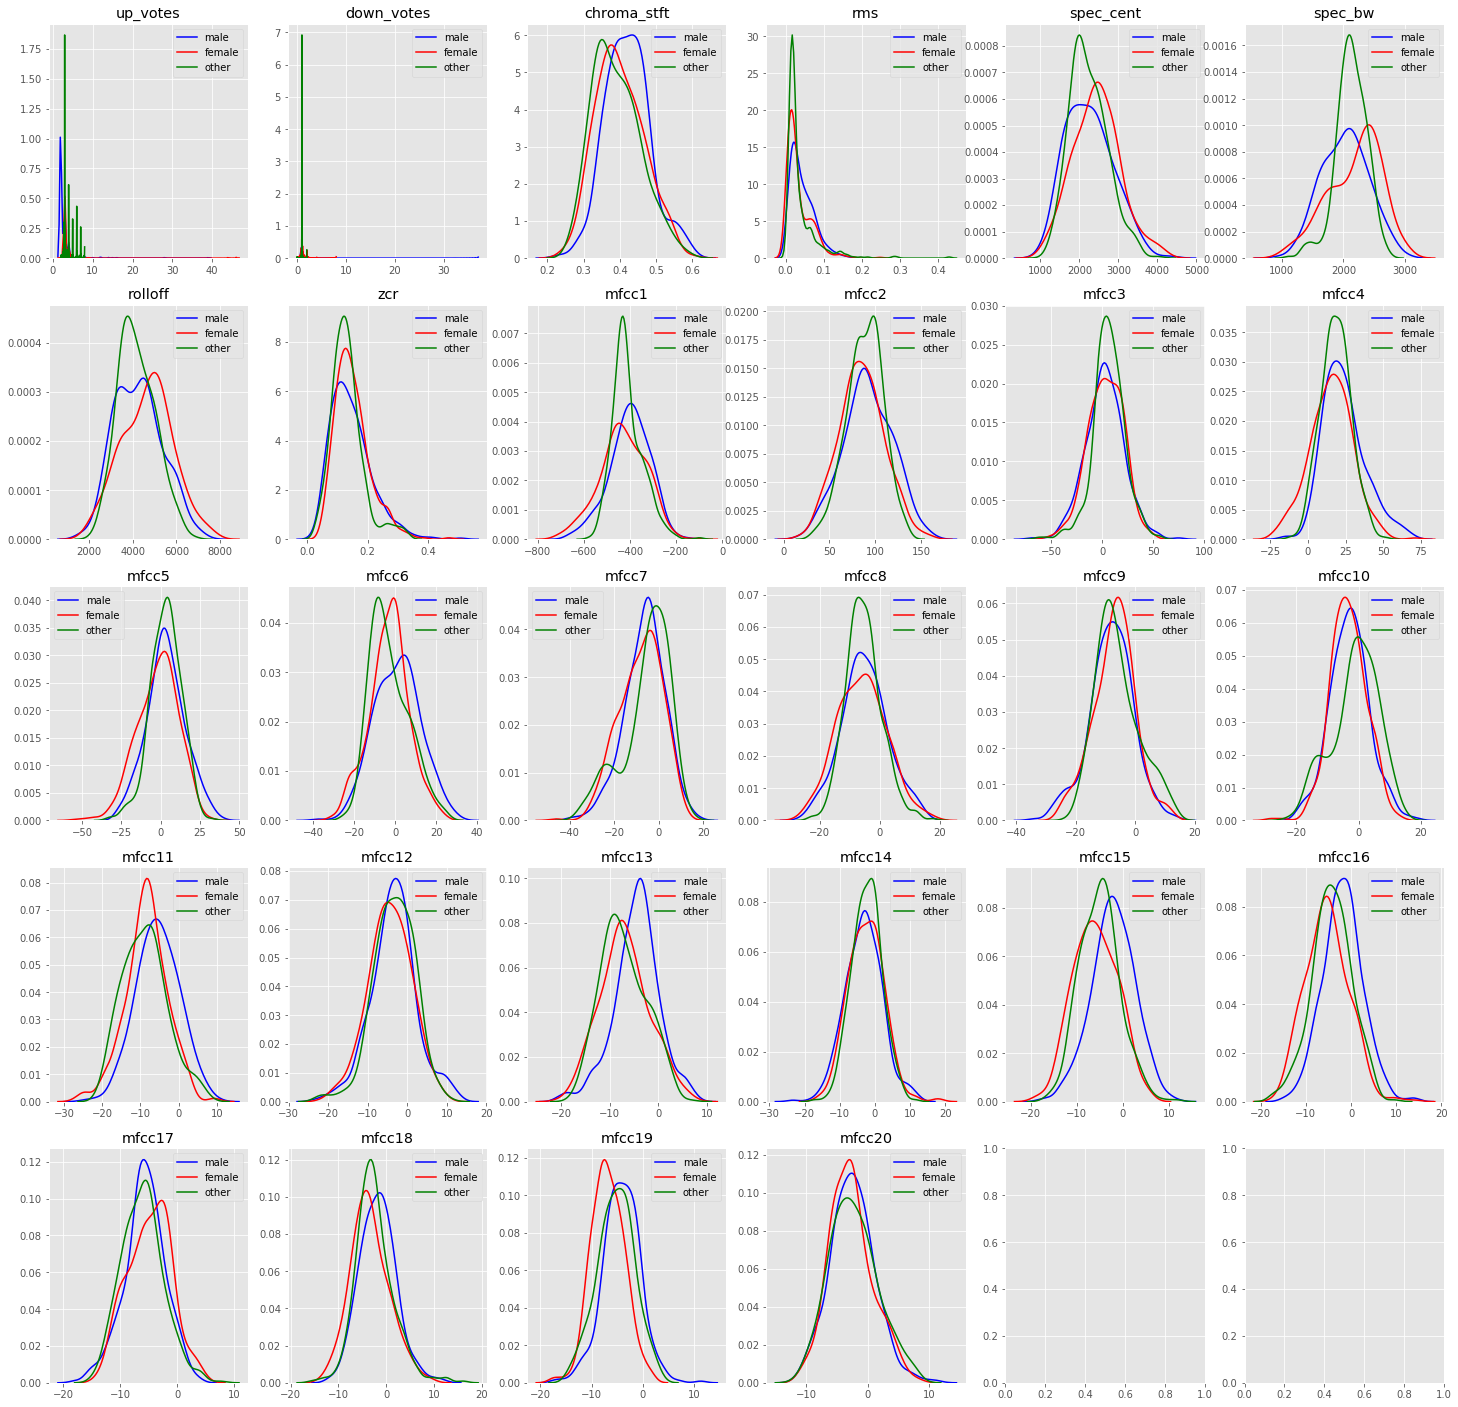

In [17]:
data = data_gender.copy()
data = data.drop(["path"],axis=1)
data = data.drop(["age"],axis=1)
data = data.drop(["accent"],axis=1)
plt.subplots(5,6,figsize=(25,25))
male_subset = data.loc[data["gender"] == "male"]
female_subset = data.loc[data["gender"]=="female"]
other_subset = data.loc[data["gender"]=="other"]
data = data.drop(["gender"],axis=1)
i = 1
for column in data.columns:
    plt.subplot(5,6,i)
    plt.title(column)
    sns.kdeplot(male_subset[column],color="blue",label="male")
    sns.kdeplot(female_subset[column],color="red",label="female")
    sns.kdeplot(other_subset[column],color="green",label="other")
    i += 1
plt.show()

# Creating some models and comparing them

In [18]:
def modelTester(name,model,features_train,features_test,target_train,target_test):
    fitted_model = model.fit(features_train,target_train)
    accuracy = accuracy_score(target_test,fitted_model.predict(features_test))
    print(name + " accuracy: " + str(accuracy))
    return fitted_model

In [19]:
#WORK IN PROGRESS - ROC (https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python)
def rocDisplayer(name,model,features_test,target_test):
    val = target_test.to_frame()
    probs = model.predict_proba(features_test)
    probs = probs[:,1]
    fpr,tpr,thresholds = metrics.roc_curve(val,probs,pos_label="male")
    roc_auc = metrics.auc(fpr, tpr)
    # ROC PLOT
    plt.title("ROC - " + name)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.show()

## Gender

In [18]:
df = data_gender.copy()
df

,up_votes,down_votes,path,age,gender,accent,chroma_stft,rms,spec_cent,spec_bw,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,2,0,data/wav_clips\common_voice_en_163185.wav,fourties,male,us,0.458923,0.034113,1686.976795,2114.252149,...,-6.066206,-4.039488,-3.869807,-2.416390,-6.074609,-3.501777,-4.234394,0.131805,-1.600934,-2.383739
1,2,0,data/wav_clips\common_voice_en_14284678.wav,twenties,male,indian,0.400219,0.012706,2577.084023,2013.609576,...,2.845031,-3.878078,-6.135597,-0.244162,-5.514540,2.514469,-6.448860,-3.445542,-5.967805,0.193436
2,3,0,data/wav_clips\common_voice_en_103423.wav,twenties,male,indian,0.466905,0.002953,1903.891727,1667.885541,...,-4.195992,-9.382774,-5.112951,-8.428408,-1.285888,-6.341369,-3.320409,-2.334014,-6.332286,-4.202587
3,3,2,data/wav_clips\common_voice_en_133313.wav,twenties,male,us,0.358183,0.063227,2355.408961,2402.296687,...,-14.582969,4.108045,2.957262,4.079654,-8.300948,3.252174,-8.146500,-0.077620,-2.866171,-5.121605
4,3,1,data/wav_clips\common_voice_en_150964.wav,teens,male,us,0.395199,0.113546,2111.540891,1629.596407,...,-3.322904,-6.027557,-6.242605,-4.127829,7.698208,-8.964873,-2.824703,-7.799104,-8.069095,-9.509217
5,3,0,data/wav_clips\common_voice_en_102844.wav,teens,male,us,0.381734,0.099241,2634.196214,1675.691330,...,-12.316536,-0.597780,-7.060400,-10.404634,-3.873715,-5.443150,-10.482459,-2.972294,0.277762,-1.899935
6,3,0,data/wav_clips\common_voice_en_157769.wav,twenties,male,us,0.358861,0.051676,1321.422532,1344.183958,...,-0.218808,-4.252911,-2.211621,-3.178681,1.183262,3.211383,-2.868867,-7.083762,-5.189325,-5.632672
7,2,0,data/wav_clips\common_voice_en_155705.wav,thirties,male,england,0.371512,0.084165,2109.745548,1914.291430,...,-3.122835,-4.540438,-1.657262,-8.804231,2.065382,-4.007780,-6.535946,3.724467,-1.320529,-0.345377
8,2,0,data/wav_clips\common_voice_en_18525312.wav,twenties,male,england,0.445229,0.055409,2182.770891,1823.442772,...,-9.070849,-12.771836,-12.357501,-6.500154,-0.782458,0.906920,-4.915157,-0.094569,-1.775563,-4.348163
9,2,0,data/wav_clips\common_voice_en_13813871.wav,twenties,male,indian,0.360381,0.027282,2486.561724,1961.567281,...,-2.798347,-8.231693,-7.483823,1.698143,-4.983908,-2.087340,-2.930871,-5.063388,-4.687857,-0.886745


In [19]:
features = df.columns
features = features.drop(["up_votes","down_votes","path","age","gender","accent"])
features

Index(['chroma_stft', 'rms', 'spec_cent', 'spec_bw', 'rolloff', 'zcr', 'mfcc1',
       'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9',
       'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16',
       'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20'],
      dtype='object')

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df[features],df.gender,train_size=0.7)

In [21]:
#Decision tree
dct = modelTester("Decision Tree",DecisionTreeClassifier(criterion='entropy'),X_train,X_test,y_train,y_test)
dct

Decision Tree accuracy: 0.5806451612903226


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [22]:
#Random forest
rf = modelTester("Random forest",RandomForestClassifier(n_estimators=1000),X_train,X_test,y_train,y_test)
rf

Random forest accuracy: 0.8225806451612904


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [23]:
#SVM linear
svm_l = modelTester("SVM linear",SVC(kernel='linear',probability=True),X_train,X_test,y_train,y_test)
svm_l

SVM linear accuracy: 0.6827956989247311


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [24]:
# SVM POLY
#modelTester("SVM POLY",SVC(kernel='poly', degree=2 ,gamma='auto',probability=True),X_train,X_test,y_train,y_test)

In [25]:
# SVM RBF
#modelTester("SVM RBF",SVC(kernel='rbf',gamma='auto',probability=True),X_train,X_test,y_train,y_test)

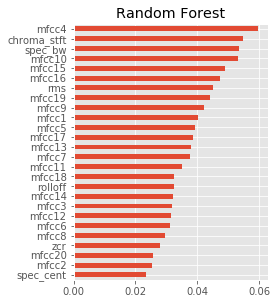

In [26]:
plt.subplots(figsize=(16, 16))
x = np.arange(-5,5,0.25)
y = np.arange(-5,5,0.25)
xx, yy = np.meshgrid(x, y)
df = pd.DataFrame({'x':xx.flatten(),'y':yy.flatten()})


feature_importances_rf = pd.Series(rf.feature_importances_, index= X_train.columns)
plt.subplot(3,4,1)
plt.title('Random Forest')
feature_importances_rf.sort_values().plot(kind='barh')

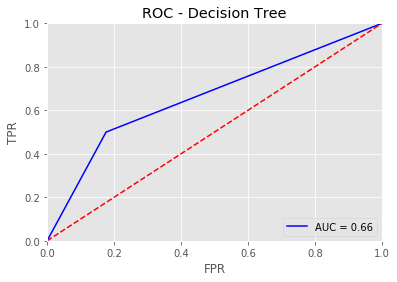

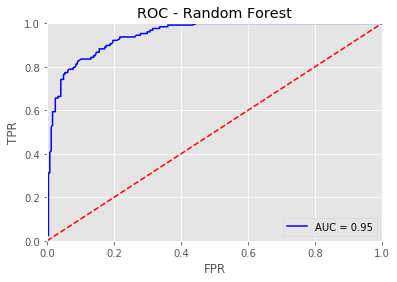

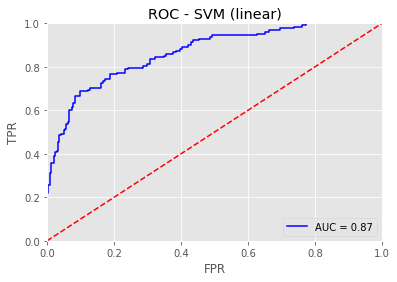

In [27]:
rocDisplayer("Decision Tree",dct,X_test,y_test)
rocDisplayer("Random Forest",rf,X_test,y_test)
rocDisplayer("SVM (linear)",svm_l,X_test,y_test)

# More gender prediction

Because there are not a lot of entries "other". We will remove them and that way we can get a lot more balanced data with just male and female entries.

In [20]:
df = pd.read_csv(output_pathname, encoding="utf-8", sep="\t")
dataGender = df.copy()
dataGender = dataGender[dataGender.gender != "other"]
dataGender = dataBalancer(dataGender,"gender",minimum_count)

features = dataGender.columns
features = features.drop(["up_votes","down_votes","path","age","gender","accent"])

X_train, X_test, y_train, y_test = train_test_split(df[features],df.gender,train_size=0.7)
#Random forest
rf = modelTester("Random forest",RandomForestClassifier(n_estimators=1000),X_train,X_test,y_train,y_test)
rf

Random forest accuracy: 0.9306847785634537


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
#SVM linear
#svm_l = modelTester("SVM linear",SVC(kernel='linear',probability=True),X_train,X_test,y_train,y_test)
#svm_l

We also have found audio features for an estonian dataset. Lets see how well does it perform on the model we just trained on the english dataset.

In [21]:
dataEst = pd.read_csv("Datasets/Dataset_EST.csv")
y_est = dataEst.gender
X_est = dataEst.drop(["path","age","gender"],axis=1)
X_est = print(accuracy_score(y_est,rf.predict(X_est)))



0.8100212175616125


# Accent

In [22]:
df = data_accent.copy()
df

,up_votes,down_votes,path,age,gender,accent,chroma_stft,rms,spec_cent,spec_bw,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,2,0,data/wav_clips\common_voice_en_164654.wav,fourties,male,us,0.312386,0.063784,1433.869665,1966.669326,...,-7.490257,-7.192475,-7.910583,-5.453124,-6.074145,-8.785640,-7.587930,-3.541024,-3.924126,-4.942614
1,3,1,data/wav_clips\common_voice_en_163823.wav,fourties,male,us,0.394926,0.074295,1349.815278,1736.823354,...,-3.021088,-4.744426,-9.031732,-2.809467,-1.825926,-4.533709,-4.156862,-2.035286,-3.642969,-2.995307
2,4,0,data/wav_clips\common_voice_en_14197.wav,twenties,male,us,0.339276,0.023694,2144.443230,1759.556849,...,-2.530444,-10.523355,-6.544351,-14.532537,7.374304,-8.184591,-8.716461,-3.025989,-9.245604,-3.147712
3,3,0,data/wav_clips\common_voice_en_108122.wav,thirties,female,us,0.413544,0.018885,3142.331240,2806.695390,...,-14.803236,-7.570687,-12.967965,-9.328629,-8.680948,-1.781445,-8.690693,-7.421591,-12.127746,3.053696
4,3,0,data/wav_clips\common_voice_en_621186.wav,twenties,male,us,0.423393,0.052649,2414.811139,1999.667981,...,-5.796454,-6.272080,-3.546398,-7.839307,-1.288325,-4.215989,-9.038208,-6.802231,-6.413251,-0.051639
5,2,0,data/wav_clips\common_voice_en_162257.wav,sixties,male,us,0.463221,0.063049,2032.198963,2053.728447,...,-6.434840,-8.424415,-5.474614,-8.766336,3.066231,-4.337437,-6.415860,1.087278,-0.438084,-4.092967
6,2,0,data/wav_clips\common_voice_en_145511.wav,twenties,male,us,0.352683,0.069669,2215.455624,1874.189692,...,-12.313941,-3.333191,-9.403816,-7.372596,-1.144575,-4.209771,-6.294001,-1.753494,-3.605405,-5.580202
7,3,0,data/wav_clips\common_voice_en_129693.wav,thirties,male,us,0.391908,0.077295,2442.066732,2212.146771,...,-6.931468,-6.349979,-2.852425,-0.068251,-4.139361,-9.797425,-7.805901,2.253062,-7.861743,-3.087515
8,2,0,data/wav_clips\common_voice_en_17697186.wav,twenties,female,us,0.334767,0.057231,2958.093744,1868.906106,...,-11.309240,-3.564338,-6.449593,-9.545376,-8.229216,-4.598121,-15.826279,-0.657840,-7.770096,-8.060610
9,2,0,data/wav_clips\common_voice_en_1237126.wav,twenties,male,us,0.338493,0.006072,2283.673079,2685.250642,...,-11.474763,-4.522444,-1.801358,1.975503,3.398740,-0.894348,-4.551209,-3.129033,-1.909827,-0.963147


In [23]:
features = df.columns
features = features.drop(["up_votes","down_votes","path","age","gender","accent"])

## 3 PCA

In [24]:
pca = PCA(n_components=3)
df_reduced = pd.DataFrame(pca.fit_transform(df[features].copy()))
df_reduced.insert(0,"accent",df["accent"],True)
df_reduced_3 = df_reduced.copy()

In [25]:
a = df_reduced["accent"].value_counts().iteritems()
groups = []
for index, value in a:
    groups.append(index)

super_colors = ["lightcoral","maroon","chocolate","gold","olive","greenyellow","darkseagreen","green","turquoise","dodgerblue","navy","darkorchid","darkmagenta"]
random.shuffle(super_colors)
colors = super_colors[:len(groups)]

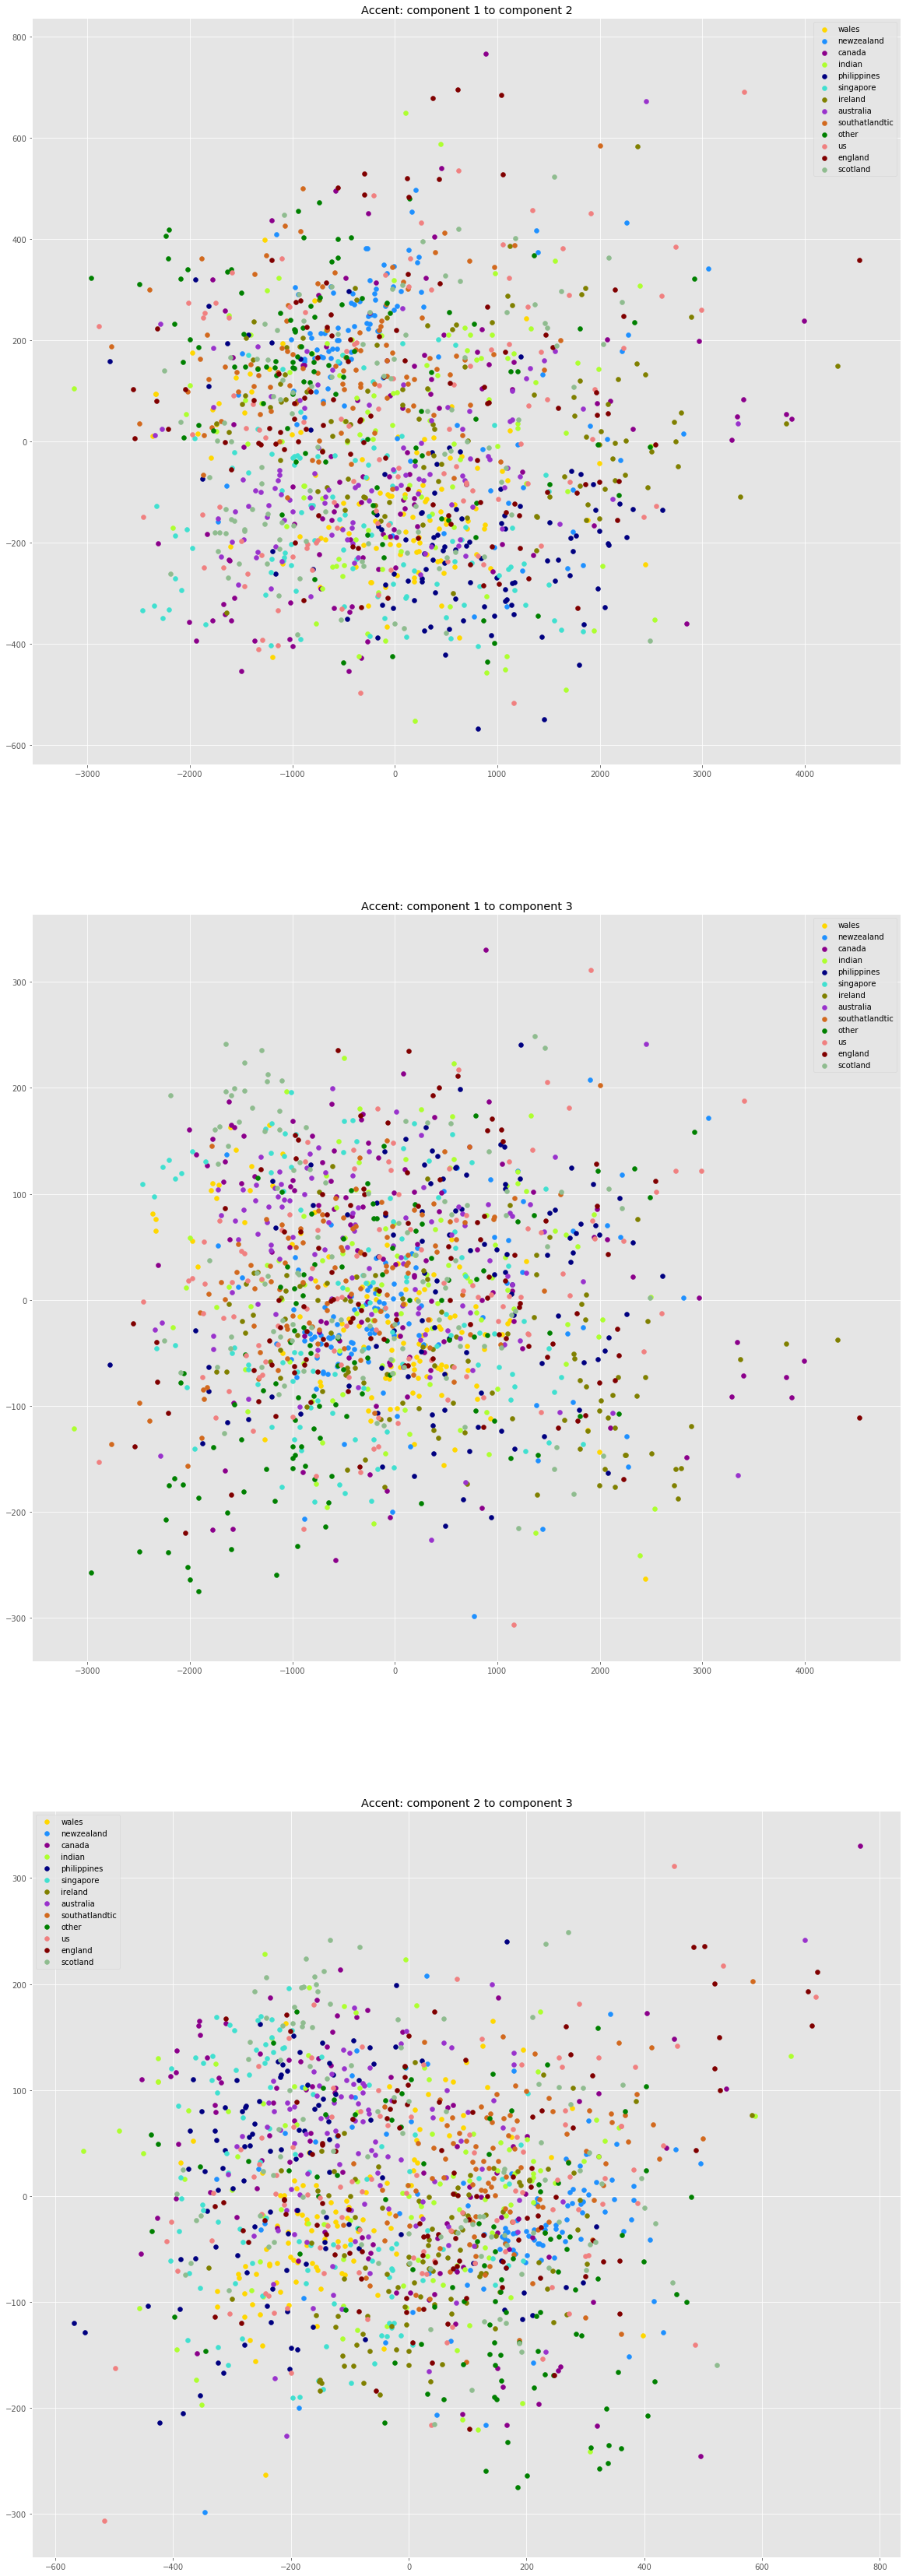

In [26]:
# Create plot
fig = plt.figure(figsize=(20,60))

ax = fig.add_subplot(311)
for color, group in zip(colors, groups):
    df_group = df_reduced[df_reduced["accent"] == group]
    xs = list(df_group[0])
    ys = list(df_group[1])
    ax.scatter(xs, ys, color=color)
ax.legend(groups)
plt.title('Accent: component 1 to component 2')

ax = fig.add_subplot(312)
for color, group in zip(colors, groups):
    df_group = df_reduced[df_reduced["accent"] == group]
    xs = list(df_group[0])
    zs = list(df_group[2])
    ax.scatter(xs, zs, color=color)
ax.legend(groups)
plt.title('Accent: component 1 to component 3')

ax = fig.add_subplot(313)
for color, group in zip(colors, groups):
    df_group = df_reduced[df_reduced["accent"] == group]
    ys = list(df_group[1])
    zs = list(df_group[2])
    ax.scatter(ys, zs, color=color)
ax.legend(groups)
plt.title('Accent: component 2 to component 3')

plt.show()

## 2PCA

In [ ]:
pca = PCA(n_components=2)
df_reduced = pd.DataFrame(pca.fit_transform(df[features].copy()))
df_reduced.insert(0,"accent",df["accent"],True)
df_reduced_2 = df_reduced.copy()

In [ ]:
# Groups
a = df_reduced["accent"].value_counts().iteritems()
groups = []
for index, value in a:
    groups.append(index)

# Colors
super_colors = ["lightcoral","maroon","chocolate","gold","olive","greenyellow","darkseagreen","green","turquoise","dodgerblue","navy","darkorchid","darkmagenta"]
random.shuffle(super_colors)
colors = super_colors[:len(groups)]

# Create plot
fig = plt.figure(figsize=(20,60))

ax = fig.add_subplot(311)
for color, group in zip(colors, groups):
    df_group = df_reduced[df_reduced["accent"] == group]
    xs = list(df_group[0])
    ys = list(df_group[1])
    ax.scatter(xs, ys, color=color)
ax.legend(groups)
plt.title('Accent: component 1 to component 2')

plt.show()

### Classification

In [ ]:
def tryClassifiersForData(data,do_dct,do_rf,do_svc,do_mlp):
    
    a = df_reduced["accent"].value_counts().iteritems()
    groups = []
    for index, value in a:
        groups.append(index)
    
    features = data.columns
    for f in ["up_votes","down_votes","path","age","gender","accent"]:
        if f in features:
            features = features.drop(f)
    
    X_train, X_test, y_train, y_test = train_test_split(data[features],data.accent,train_size=0.7)
    
    if (do_dct):
        dct = modelTester("Decision Tree",DecisionTreeClassifier(criterion='entropy'),X_train,X_test,y_train,y_test)
    if (do_rf):
        rf = modelTester("Random forest",RandomForestClassifier(n_estimators=10000),X_train,X_test,y_train,y_test)
    if (do_svc):
        svm_s = modelTester("SVC",SVC(kernel='rbf',shrinking=False,gamma="scale"),X_train,X_test,y_train,y_test)
    if (do_mlp):
        mlp = modelTester("MLPClassifier",MLPClassifier(),X_train,X_test,y_train,y_test)

In [ ]:
tryClassifiersForData(df,1,0,1,1)

In [ ]:
tryClassifiersForData(df_reduced_3,1,0,1,1)

In [ ]:
tryClassifiersForData(df_reduced_2,1,0,1,1)

# Neural Networks

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.optimizers import SGD

In [ ]:
def neural_network(hidden_size=5,learning_rate=0.1,momentum=0.9,weights=None):
    
    # One feature per sample
    x = Input((1,))

    # 5 hidden nodes with sigmoid as activation function
    h = Dense(hidden_size,activation='sigmoid',bias_initializer='random_uniform')(x)

    # One output with linear activation function.
    out = Dense(1,activation='linear',bias_initializer='random_uniform')(h)

    # Define a model
    model = Model(inputs=[x],outputs=[out])

    # Stochastic gradient descent with the specificed
    # learning rate and momentum.
    optimizer = SGD(lr=learning_rate,momentum=momentum)

    # Compile the model to generate the computation graph
    model.compile(optimizer=optimizer,loss='mse')
    if weights is not None:
        model.set_weights(weights)
        
    return model